# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

**Структура данных:**

- `сalls` — количество звонков
- `minutes` — суммарная длительность звонков в минутах
- `messages` — количество sms-сообщений
- `mb_used` — израсходованный интернет-трафик в Мб
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0)

**План работы:**

- изучим файл с данными;
- разобьем данные на три выборки: обучающая, валидационная и тестовая;
- исследуем три модели классификации: дерево решений, случайный лес и логистическая регрессия;
- найдем оптимальные параметры для каждой модели и выберем одну из них для обучения модели;
- оценим точность обученной модели;
- оценим адекватность модели.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams ['figure.figsize'] = [13, 6]

## Откроем и изучим файл

In [4]:
try:
    df = pd.read_csv('/datasets/users_behavior.csv')
except:
    df = pd.read_csv('users_behavior.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [6]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [7]:
df['is_ultra'].unique()

array([0, 1])

**Вывод:** Имеем датасет на 3214 строки. В качестве целевого признака будем использовать столбец `is_ultra`. Столбец имеет только 2 уникальных значения, поэтому перед нами задача классификации. Остальные стобцы будем использовать в качестве признаков.

## Разобьем данные на выборки

In [8]:
df_train, df_test1 = train_test_split(df, test_size=0.4, random_state=54123)
df_test, df_val = train_test_split(df_test1, test_size=0.5, random_state=54123)

print('Размер обучающей выборки: {}'.format(df_train.shape[0]))
print('Размер валидационной выборки: {}'.format(df_val.shape[0]))
print('Размер тестовой выборки: {}'.format(df_test.shape[0]))

Размер обучающей выборки: 1928
Размер валидационной выборки: 643
Размер тестовой выборки: 643


In [9]:
features_train = df_train.drop('is_ultra', axis=1)
target_train = df_train['is_ultra']
features_val = df_val.drop('is_ultra', axis=1)
target_val = df_val['is_ultra']
features_test = df_test.drop('is_ultra', axis=1)
target_test = df_test['is_ultra']

Посмотрим распределение по данным:

In [10]:
target_train.value_counts(normalize=True)

0    0.689834
1    0.310166
Name: is_ultra, dtype: float64

In [11]:
target_val.value_counts(normalize=True)

0    0.674961
1    0.325039
Name: is_ultra, dtype: float64

In [12]:
target_test.value_counts(normalize=True)

0    0.723173
1    0.276827
Name: is_ultra, dtype: float64

**Вывод:** Данные разбиты по принципу 60/20/20 и подготовлены для обучения модели. Данные несбалансированны.

## Исследуем модели

Сделаем функцию для построения графиков при использовании различных гиперпараметров:

In [28]:
def graf(z:dict, typ, *args):
    x = []
    y = []
    title_type = {
        'dtc': 'Гиперпараметры: splitter={}, criterion={}',
        'rfc': 'Гиперпараметры: criterion={}',
        'lr': 'Гиперпараметры: solver={}'
    }
    xlabel_type = {
        'dtc': 'Максимальная глубина',
        'rfc': 'Количество деревьев в лесу',
        'lr': 'Количество итераций'
    }
    ylabel_type = {
        'dtc': 'Доля правильных ответов',
        'rfc': 'Лучший показатель доли правильных ответов',
        'lr': 'Доля правильных ответов'
    }
    
    for k, v in z.items():
        x.append(k)
        y.append(v)
    
    ax = plt.subplot(111)
    plt.plot(x, y, 'o-')
    plt.title(title_type[typ].format(*args), fontsize=16)
    plt.xlabel(xlabel_type[typ], fontsize=14)
    plt.ylabel(ylabel_type[typ], fontsize=14)
    plt.grid(True)
    if typ == 'dtc':
        ax.set_xticks([x for x in range(1,len(z)+1)])

    plt.show()

Для начала подберем геперпараметры для наилучшей модели дерева решений:

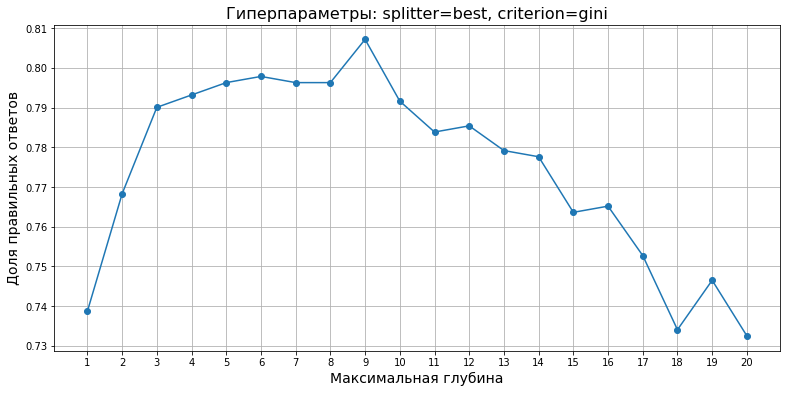

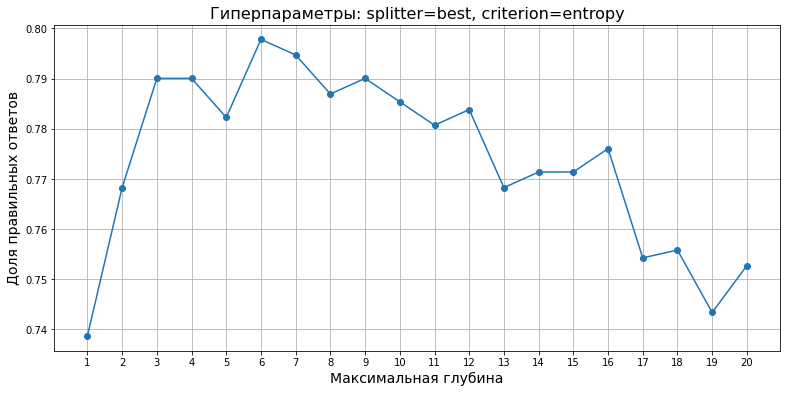

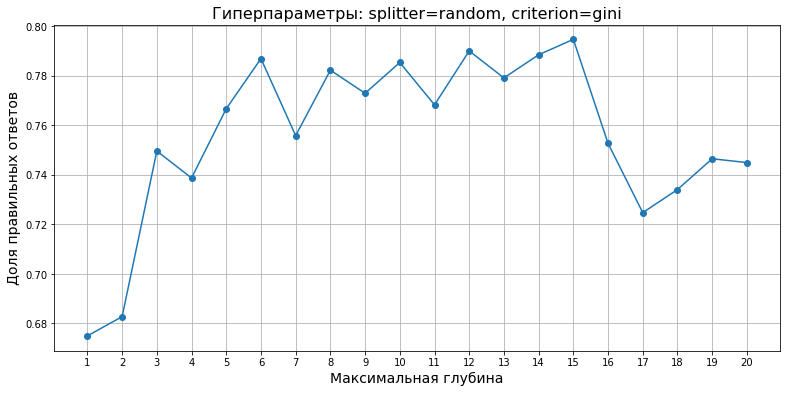

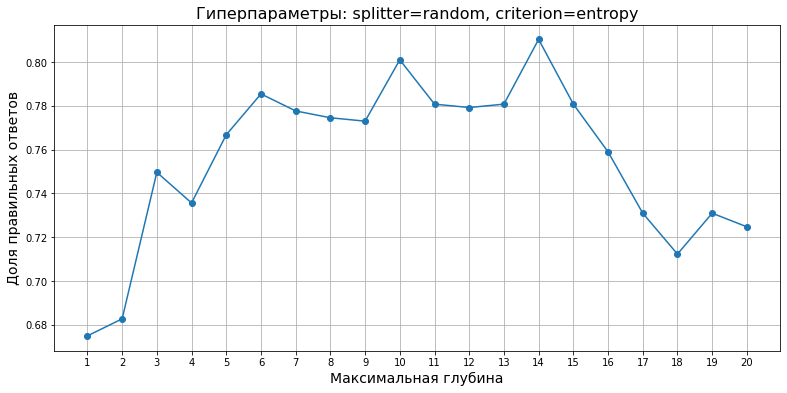


Лучший показатель доли правильных ответов = 0.8102643856920684.
Используемые гиперпараметры: max_depth=14, splitter=random, criterion=entropy


In [29]:
best_depth = 0
best_accuracy = 0
best_splitter = ''
best_criterion = ''

for splitter in ['best', 'random']:
    for criterion in ['gini', 'entropy']:
        z = {}
        z.clear()
        for depth in range(1, 21):
            model = DecisionTreeClassifier(random_state=54123, max_depth=depth, criterion=criterion, splitter=splitter)
            model.fit(features_train, target_train)
            predictions_val = model.predict(features_val)
            accuracy_val = accuracy_score(target_val, predictions_val)
            z[depth] = accuracy_val
            if best_accuracy < accuracy_val:
                best_accuracy = accuracy_val
                best_depth = depth
                best_splitter = splitter
                best_criterion = criterion
        graf(z, 'dtc', splitter, criterion)


print()
print('Лучший показатель доли правильных ответов = {}.'.format(best_accuracy))
print('Используемые гиперпараметры: max_depth={}, splitter={}, criterion={}'.format(best_depth, best_splitter, best_criterion))

Лучшими гиперпараметрами для `DecisionTreeClassifier` являются *max_depth=14, splitter='random', criterion='entropy'*. Сохраним модель дерева решений с такими гиперпараметрами:

In [15]:
dtc_model = DecisionTreeClassifier(random_state=54123, max_depth=14, criterion='entropy', splitter='random')
dtc_model.fit(features_train, target_train)

DecisionTreeClassifier(criterion='entropy', max_depth=14, random_state=54123,
                       splitter='random')

Теперь протестируем модель случайного леса с различными гиперпараметрами:

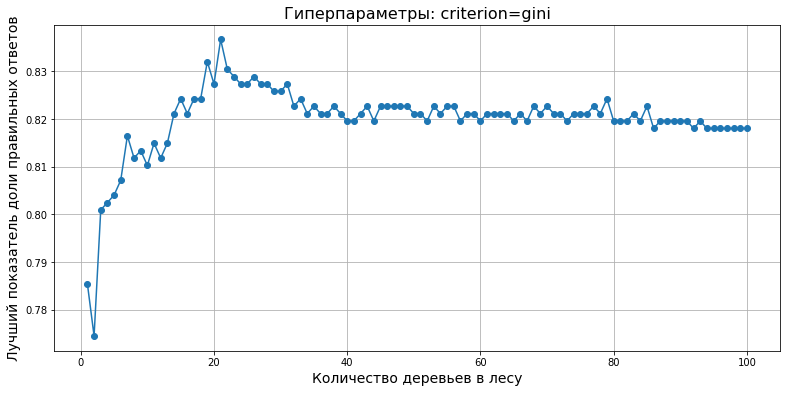

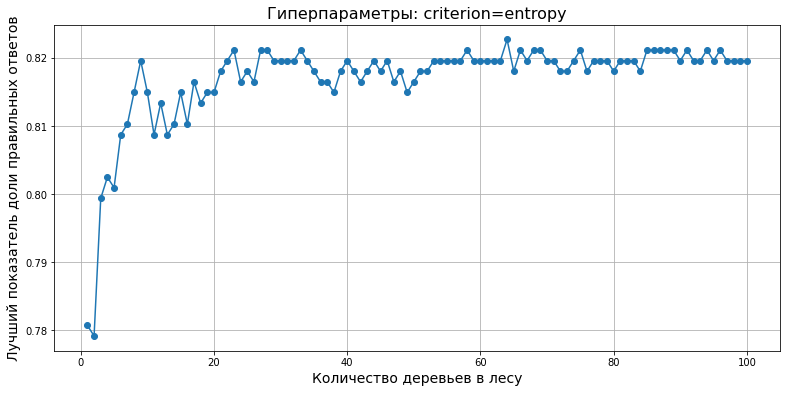


Лучший показатель доли правильных ответов = 0.8367029548989113.
Используемые гиперпараметры: max_depth=15, n_estimators=21, criterion=gini


In [16]:
best_depth = 0
best_accuracy = 0
best_n_estimators = 0
best_criterion = ''

for criterion in ['gini', 'entropy']:
    z = {}
    z.clear()
    for est in range(1, 101):
        b_est_accuracy = 0
        for depth in range(1, 21):
            model = RandomForestClassifier(random_state=54123, max_depth=depth, criterion=criterion, n_estimators=est)
            model.fit(features_train, target_train)
            predictions_val = model.predict(features_val)
            accuracy_val = accuracy_score(target_val, predictions_val)
            if best_accuracy < accuracy_val:
                best_accuracy = accuracy_val
                best_depth = depth
                best_n_estimators = est
                best_criterion = criterion
            if b_est_accuracy < accuracy_val:
                b_est_accuracy = accuracy_val
        z[est] = b_est_accuracy
    graf(z, 'rfc', criterion)

print()
print('Лучший показатель доли правильных ответов = {}.'.format(best_accuracy))
print('Используемые гиперпараметры: max_depth={}, n_estimators={}, criterion={}'.format(
    best_depth, best_n_estimators, best_criterion
))

Лучшими гиперпараметрами для `RandomForestClassifier` являются *max_depth=15, n_estimators=21, criterion='gini'*. Сохраним модель случайного леса с такими гиперпараметрами:

In [17]:
rfc_model = RandomForestClassifier(random_state=54123, max_depth=15, criterion='gini', n_estimators=21)
rfc_model.fit(features_train, target_train)

RandomForestClassifier(max_depth=15, n_estimators=21, random_state=54123)

Модель логической регрессии с различными гиперпараметрами:

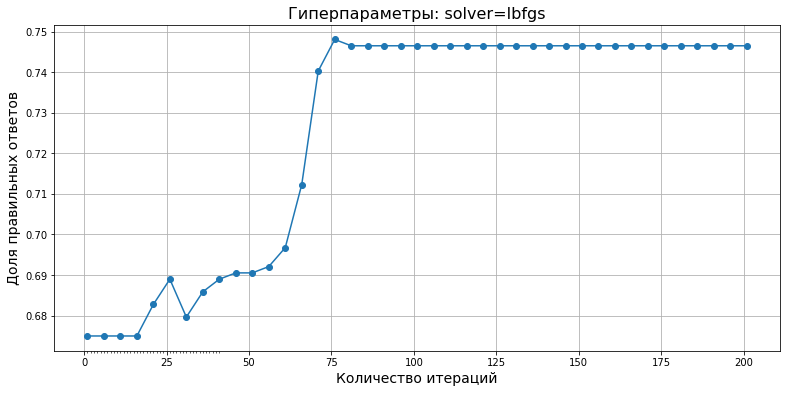

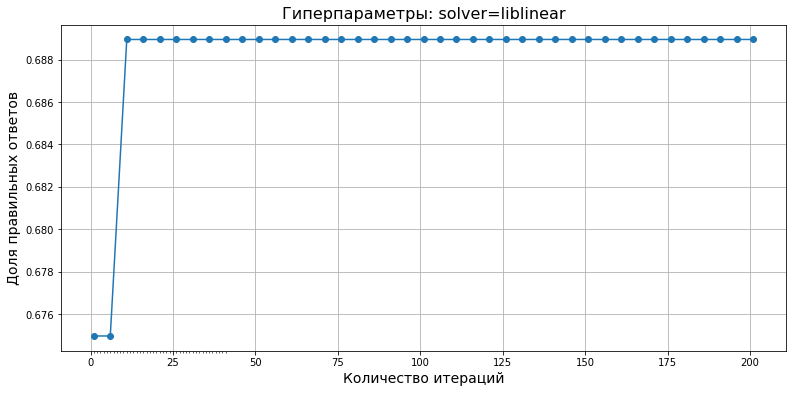

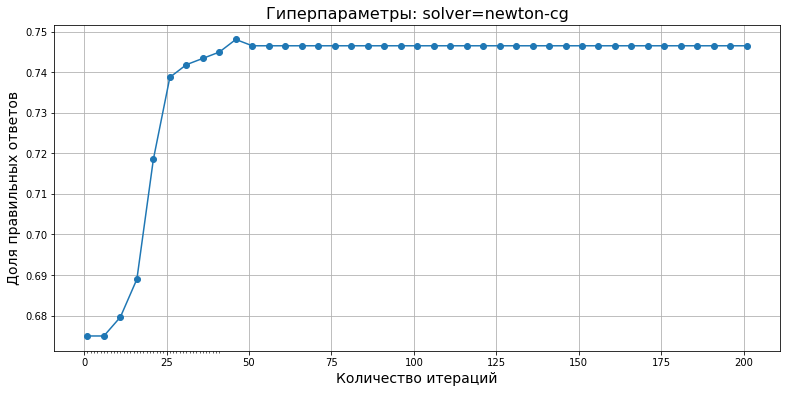

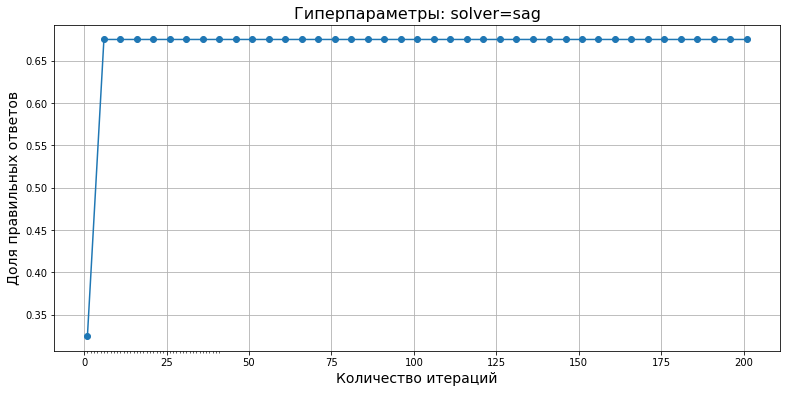

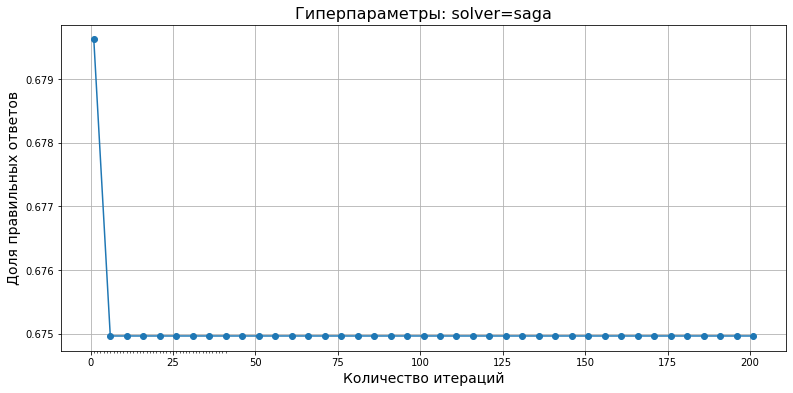


Лучший показатель доли правильных ответов = 0.7480559875583204.
Используемые гиперпараметры: max_iter=76, solver=lbfgs


In [27]:
best_max_iter = 0
best_accuracy = 0
best_solver = ''


for solver in ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']:
    z = {}
    z.clear()
    for max_iter in range(1, 202, 5):
        model = LogisticRegression(random_state=54123, max_iter=max_iter, solver=solver)
        model.fit(features_train, target_train)
        predictions_val = model.predict(features_val)
        accuracy_val = accuracy_score(target_val, predictions_val)
        z[max_iter] = accuracy_val
        if best_accuracy < accuracy_val:
            best_accuracy = accuracy_val
            best_max_iter = max_iter
            best_solver = solver
    graf(z, 'lr', solver)
    

print()
print('Лучший показатель доли правильных ответов = {}.'.format(best_accuracy))
print('Используемые гиперпараметры: max_iter={}, solver={}'.format(best_max_iter, best_solver))

Лучшими гиперпараметрами для `LogisticRegression` являются *max_iter=76, solver='lbfgs'*. Сохраним модель логической регрессии с такими гиперпараметрами:

In [19]:
lr_model = LogisticRegression(random_state=54123, max_iter=76, solver='lbfgs')
lr_model.fit(features_train, target_train)

LogisticRegression(max_iter=76, random_state=54123)

**Вывод:** В ходе исследования были получены следующие данные:

- Доля правильных ответов модели дерева решений при глубине 14 равна 0.8102 (splitter=random, criterion=entropy).
- Доля правильных ответов модели случайного леса при количестве деревьев 21, глубине 15 равна 0.8367 (criterion=gini).
- Доля правильных ответов модели логистической регресии равна 0.7480 (solver=lbfgs). 

Лучший результат показывает модель случайного леса с гиперпараметрами max_depth=15, n_estimators=21.

## Проверим модель на тестовой выборке

Оценим точность наших моделей на тестовой выборке:

In [20]:
test_predictions = dtc_model.predict(features_test)
accuracy = accuracy_score(target_test, test_predictions)
print('Доля правильных ответов модели дерева решений на тестовой выборке',accuracy)

test_predictions = rfc_model.predict(features_test)
accuracy = accuracy_score(target_test, test_predictions)
print('Доля правильных ответов модели случайного леса на тестовой выборке',accuracy)

test_predictions = lr_model.predict(features_test)
accuracy = accuracy_score(target_test, test_predictions)
print('Доля правильных ответов модели логистической регресиии на тестовой выборке',accuracy)

Доля правильных ответов модели дерева решений на тестовой выборке 0.7869362363919129
Доля правильных ответов модели случайного леса на тестовой выборке 0.8102643856920684
Доля правильных ответов модели логистической регресиии на тестовой выборке 0.7682737169517885


**Вывод:** для решения задачи мы можем выбрать любую из созданных моделей. Каждая их них дает результат предсказания выше 0.75. Лидирующей моделью является модель смешанного леса с результатом доли правильных ответов в 0.810.

## (бонус) Проверим модели на адекватность

В качестве оценки адекватности модели будем использовать несколько метрик:
- **accuracy** - доля правильных ответов;
- **precision** - доля правильно предсказанных положительных объектов среди всех объектов, предсказанных положительным классом;
- **recall** - доля правильно найденных положительных объектов среди всех объектов положительного класса;
- **f1-мера** - среднее гармоническое precision и recall.

Оценивать будем только модель случайного леса, т.к. она показала лучший результат:

In [21]:
report = classification_report(target_test, rfc_model.predict(features_test), target_names=['0', '1'])
print(report)

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       465
           1       0.69      0.57      0.62       178

    accuracy                           0.81       643
   macro avg       0.77      0.74      0.75       643
weighted avg       0.80      0.81      0.80       643



Для сравнения сделаем простую модель `DummyClassifier` и посмотрим ее результаты:

In [22]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_train, target_train)
report = classification_report(target_test, dummy_clf.predict(features_test), target_names=['0', '1'])
print(report)

              precision    recall  f1-score   support

           0       0.72      1.00      0.84       465
           1       0.00      0.00      0.00       178

    accuracy                           0.72       643
   macro avg       0.36      0.50      0.42       643
weighted avg       0.52      0.72      0.61       643



**Вывод:** По сравнению с базовой моделью, модель случайного леса показывает лучшие результаты. Доля правльных ответов у базовой модели составила 72%, у модели случайного леса - 81%.

Несмотря на то, что доля правильных ответов в моделе случайного леса составила 0.81 другие метрики показали отличающиеся результаты. *Precision* составляет 0.69, а *recall* - 0.57. Среднее гармоническое обеих метрик *(f1-мера)* является 0.62.

## Общий вывод

В ходе проделанной работы:
- изучили файл с данными (3214 строки, пропуски отсутсвуют);
- разбили данные на три выборки (в соотношении 3:1:1): обучающая, валидационная и тестовая. В качестве целевого признака использовали столбец `is_ultra`. Данные несбалансированны;
- исследовали три модели классификации: дерево решений, случайный лес и логистическая регрессия;
- нашли оптимальные гиперпараметры для каждой модели:
    - дерево решений: *max_depth=14, criterion='entropy', splitter='random'*;
    - случайный лес: *max_depth=15, criterion='gini', n_estimators=21*;
    - логистическая регресия: *max_iter=76, solver='lbfgs'*.
- оценили точность обученной модели:
    - доля правильных ответов модели дерева решений на тестовой выборке *0.7869362363919129*;
    - доля правильных ответов модели случайного леса на тестовой выборке *0.8102643856920684*;
    - доля правильных ответов модели логистической регресиии на тестовой выборке *0.7682737169517885*;
- каждая из обученных моделей соответствует условию задачи и выдает правильный ответ более чем в 75% случаях.
- оценили адекватность модели случайного леса: f1-мера нашей модели равняется 0.62, что указывает на среднее качество нашей модели.